In [702]:
%config IPCompleter.greedy=True

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Final Introduction to AI course : COVID-19 Analysis and Predictions

## Introduction: Dataset

Authors of the dataset: 
Xu, Bo and Gutierrez, Bernardo and Mekaru, Sumiko and Sewalk, Kara and Goodwin, Lauren and Loskill, Alyssa and  Cohn, Emily and Hswen, Yulin and Hill, Sarah C. and Cobo, Maria M and Zarebski, Alexander and Li, Sabrina and Wu, Chieh-Hsi   and Hulland, Erin and Morgan, Julia and Wang, Lin and O'Brien, Katelynn and Scarpino, Samuel V. and Brownstein, John S. and Pybus, Oliver G. and Pigott, David M. and Kraemer, Moritz U. G.

Article about the dataset: [Epidemiological data from the COVID-19 outbreak, real-time case information}](https://www.doi.org/10.1038/s41597-020-0448-0)

Github : https://github.com/beoutbreakprepared/nCoV2019

In [703]:
#path = ('https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/outside_hubei_20200301.csv')
path = "latestdata.csv"

df = pd.read_csv(path)
df.head()

,ID,age,sex,city,province,country,latitude,longitude,geo_resolution,date_onset_symptoms,...,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials,travel_history_binary
0,000-1-1,NaN,male,Shek Lei,Hong Kong,China,22.365019,114.133808,point,NaN,...,NaN,NaN,Shek Lei,NaN,NaN,Hong Kong,China,8051.0,NaN,NaN
1,000-1-10,78,male,Vo Euganeo,Veneto,Italy,45.297748,11.658382,point,NaN,...,22.02.2020,NaN,Vo' Euganeo,NaN,NaN,Veneto,Italy,8978.0,NaN,NaN
2,000-1-100,61,female,NaN,NaN,Singapore,1.353460,103.815100,admin0,NaN,...,17.02.2020,NaN,NaN,NaN,NaN,NaN,Singapore,201.0,NaN,NaN
3,000-1-1000,NaN,NaN,Zhengzhou City,Henan,China,34.629310,113.468000,admin2,NaN,...,NaN,NaN,NaN,NaN,Zhengzhou City,Henan,China,10115.0,NaN,NaN
4,000-1-10000,NaN,NaN,Pingxiang City,Jiangxi,China,27.513560,113.902900,admin2,NaN,...,NaN,NaN,NaN,NaN,Pingxiang City,Jiangxi,China,7079.0,NaN,NaN


In [704]:
df.columns

Index(['ID', 'age', 'sex', 'city', 'province', 'country', 'latitude',
       'longitude', 'geo_resolution', 'date_onset_symptoms',
       'date_admission_hospital', 'date_confirmation', 'symptoms',
       'lives_in_Wuhan', 'travel_history_dates', 'travel_history_location',
       'reported_market_exposure', 'additional_information',
       'chronic_disease_binary', 'chronic_disease', 'source',
       'sequence_available', 'outcome', 'date_death_or_discharge',
       'notes_for_discussion', 'location', 'admin3', 'admin2', 'admin1',
       'country_new', 'admin_id', 'data_moderator_initials',
       'travel_history_binary'],
      dtype='object')

In [705]:
df.describe(include="all")

,ID,age,sex,city,province,country,latitude,longitude,geo_resolution,date_onset_symptoms,...,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials,travel_history_binary
count,920737,243077,243783,716290,889612,920634,920688.000000,920688.000000,920688,164774,...,522,642,7614,9207,426434,589542,895125,920688.000000,402183,855158
unique,920737,304,2,4614,950,141,NaN,NaN,7,137,...,78,204,347,410,1961,469,137,NaN,11,2
top,007-121852,35-59,female,Moscow,Central,Russia,NaN,NaN,admin2,20.03.2020,...,18.02.2020,Could be some cases from 23rd,Chicago,Birmingham,Moscow,Central,Russia,NaN,TR,False
freq,1,66683,131809,104060,140612,198301,NaN,NaN,434954,5302,...,22,91,985,309,104058,136936,198301,NaN,386327,828363
mean,NaN,NaN,NaN,NaN,NaN,NaN,44.270574,9.667676,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6571.943791,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,15.467287,49.728425,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4131.611894,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,-54.000000,-159.727596,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,41.402211,4.590656,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1903.500000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,48.076205,10.552910,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6363.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,52.580000,37.617300,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10857.000000,NaN,NaN


# 0. Cleaning Dataset


## Age Range to average age conversion

Some of the ages are actually an age range. The goal here if to convert some age ranges to an average age.

_ex: 10-20 => 15_

In [706]:
df = df[df["age"] != "7 months"]

tmp = []

for index,value in enumerate(df["age"]): 
    try:
        if (type(value) == str):
            # some age values may be a range like : "12-20"
            age_array = value.split("-")
            if len(age_array) == 2:
                tmp.append((float(age_array[0]) + float(age_array[1])) // 2)
            else: 
                tmp.append(float(value))
        else:
            tmp.append(float(value))
    except Exception:
        tmp.append(np.NaN)
        continue

ages_transformed = pd.Series(tmp)

In [707]:
df["age"] = ages_transformed

## Outcome standarzing

The outcome types are of types :
- 'death'
- 'discharge'
- 'discharged'
- 'Discharged'
- 'recovered',
- 'dead'
- 'died'
- 'Died'

If the person died the value will be _1_ and will be _0_ if recovered/dismissed.



In [708]:

tmp = []

for value in df["outcome"]:
    if type(value) == str:
        lowered_value = value.lower()
        if lowered_value in ["dead", "died","death"]:
            tmp.append(1)
        else:
            tmp.append(0)
    else:
        tmp.append(0)
        
        
outcome_standardized = pd.Series(tmp)


In [709]:
df["outcome"] = outcome_standardized

## Droping null and NaN values

In [710]:
df = df.dropna(subset=["age", "sex","city", "outcome", "country", "province"])

In [711]:
df.shape

(166196, 33)

## Country, City, Province Standardizing

Countries are string values, for modeling and analysis  we will associate the variables to labels  

In [712]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df["country"])

df["country_code"] = le.transform(df["country"])

In [713]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df["province"])

df["province_code"] = le.transform(df["province"])

In [714]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df["city"])

df["city_code"] = le.transform(df["city"])

## Standardizing Sex

Male will be considered 1 and female will be considered 0.

In [715]:
df["sex"].unique()

array(['male', 'female'], dtype=object)

In [716]:
df["sex"].isna().sum()

0

In [717]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df["sex"])

df["sex_code"] = le.transform(df["sex"])

## Cleaning Age

Ages need to be between 1 and 130 years old and be labelled a category

In [718]:
df = df[(df["age"] <= 130) & (df["age"] > 0)]

In [719]:
age_groups = pd.cut(df["age"],bins=[0,2,17,65,130],labels=['Toddler/Baby','Child','Adult','Elderly'])
df["age_group"] = age_groups


In [720]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df["age_group"])

df["age_group_code"] = le.transform(df["age_group"])

# 1. Analysis of the Dataset

Number of people in "cleaned" dataset 

In [721]:
df.shape[0]

166184

Total number of deaths in dataset

In [722]:
df["outcome"].sum()

183.0

Number of deaths per age group and sex

In [723]:
df.pivot_table("outcome", index="sex", columns="age_group", aggfunc="sum")

age_group,Toddler/Baby,Child,Adult,Elderly
sex,,,,
female,0.0,0.0,10.0,47.0
male,0.0,0.0,55.0,71.0


Correlation matrix

## A. Variable correlation

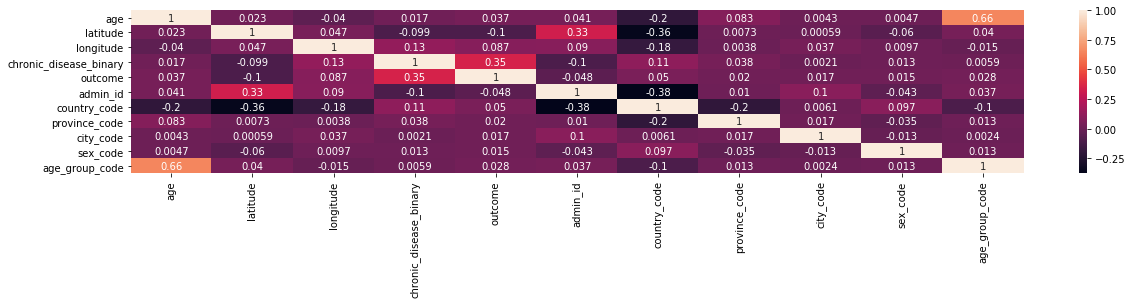

In [724]:
import seaborn as sn

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

The most correlated variables to the outcome is the chronic_disease feature.

This correlation matrix doesn't show any other notable correlation between the outcome and another feature.

## B. Plotting Cleaned Dataset using PCA

In [725]:
df_trimmed = df.drop(columns=["age_group", "country", "date_onset_symptoms","city", "province",
                     "date_death_or_discharge","notes_for_discussion","location","notes_for_discussion",
                     "ID", "geo_resolution", "date_onset_symptoms", "data_moderator_initials","travel_history_dates","date_confirmation", "travel_history_binary",
                    "country_new", "city","chronic_disease", "additional_information","source", "sequence_available","reported_market_exposure","date_admission_hospital", "symptoms", "travel_history_location",
                    "lives_in_Wuhan", "admin3", "admin2", "sex","admin1","admin_id", "latitude","province_code", "age_group_code","longitude",
                             "country_code","city_code"])

df_trimmed.head()

,age,chronic_disease_binary,outcome,sex_code
1,78.0,False,1.0,1
27,66.0,False,0.0,1
28,27.0,False,0.0,0
29,17.0,False,0.0,1
30,51.0,False,0.0,0


In [726]:
from sklearn import decomposition

Y = df_trimmed["outcome"].values
X = df_trimmed.drop(columns=["outcome"]).values # Droping useless columns (for this PCA)

pca = decomposition.PCA(n_components=2)

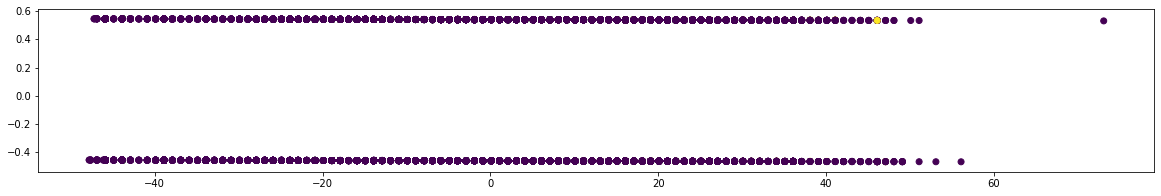

In [727]:
pca.fit(X)
X_pca = pca.transform(X)
plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], c=Y)
plt.show()

# 2. Bayes Nets 

Bayes Theorem
\begin{equation*}
P(A|B) = \frac{P(B|A) * P(A)}{P(B)}
\end{equation*}

## A. $P( Has Symptoms| Visited Wuhan)$

Question: 
What is the probability for a person to have symptoms of COVID-19
(symptom_onset=date) if this person visited Wuhan (visiting Wuhan = 1) ? Consider
that (symptom_onset=N/A) means that the patient is asymptomatic.

--- 


We are trying to solve:

\begin{equation*}
P(Has Symptoms|Visited Wuhan) = \frac{P(Has Symptoms \cap Visited Wuhan)}{P(Visited Wuhan)}
\end{equation*}




$P(VisitedWuhan)$ : the person visited Wuhan if  the _travel_history_location_ is _Wuhan_.


In [734]:
total_visited_wuhan = df[df["travel_history_location"] == "Wuhan"]["travel_history_location"].count()
total_history_location = df["travel_history_location"].count() # counting only when the data is about the location is present

p_VisitedWuhan = total_visited_wuhan / total_history_location
p_VisitedWuhan

0.18578898800369117

$P(Has Symptoms \cap Visited Wuhan)$ : the person visited Wuhan if the travel_history_location and is symptomatic

In [763]:
total = df["date_onset_symptoms"].size
total

166184

In [764]:
df["date_onset_symptoms"].isnull().sum()

56956

In [775]:
total_has_symptoms_and_visited_wuhan = df[(df["date_onset_symptoms"].isnull() == False)
                                          & (df["travel_history_location"] == "Wuhan")]["travel_history_location"].count()
total_has_symptoms_and_visited_wuhan

337

In [776]:
p_HasSymptomsAndVisitedWuhan = total_has_symptoms_and_visited_wuhan/total
p_HasSymptomsAndVisitedWuhan

0.002027872719395369

$P(Has Symptoms|Visited Wuhan)$ that we can compute from the previous probabilities 


In [778]:
p_SymptomsKnowingThatVisitedWuhan = p_HasSymptomsAndVisitedWuhan  / p_VisitedWuhan
p_SymptomsKnowingThatVisitedWuhan

0.010914924189990636

To conclude there is roughly 1.1% chance that a person who visited Wuhan has the symptoms. 

## B. $P(Has Symptoms \cap Visited Wuhan)$

What is the probability for a person to be a true patient if this person have symptoms of
COVID-19 (symptom_onset=date) and this person visited Wuhan ?

In [781]:
p_HasSymptomsAndVisitedWuhan

0.002027872719395369

There is roughly a 0.2% chance that the person has the symptoms and visited Wuhan

## C. $P(Died | Visited Wuhan)$

What is the probability for a person to death if this person visited Wuhan ?

--- 


We are trying to solve:

\begin{equation*}
P(Died|Visited Wuhan) = \frac{P(Died \cap Visited Wuhan)}{P(Visited Wuhan)}
\end{equation*}




$P(Died \cap Visited Wuhan)$ : People who died (outcome = 1.0) and who visited Wuhan.

In [795]:
total_died_and_visited_wuhan = df[(df["travel_history_location"] == "Wuhan") & (df["outcome"] == 1.0)]["travel_history_location"].count()
p_DiedAndVisitedWuhan = total_died_and_visited_wuhan/total_history_location
p_DiedAndVisitedWuhan

0.0009227929867733005

$P(Died|Visited Wuhan)$ : finally we can compute the probability of a person for death if visiting Wuhan. 

In [797]:
p_DiedKnowingThatVisitedWuhan = p_DiedAndVisitedWuhan / p_VisitedWuhan
p_DiedAndVisitedWuhan

0.0009227929867733005

To conclude there is a 0.1% chance that a person dies after visitign Wuhan. 

## D. Average Recovery Interval for a Person visiting Wuhan 

We only keep the people who visited wuhan and recovered from the COVID (outcome = 0.0 and who actually have dates relating to the times of their sickness

In [820]:
df_visiting_wuhan = df.dropna(subset=["date_onset_symptoms","date_death_or_discharge"])
df_visiting_wuhan = df_visiting_wuhan[(df_visiting_wuhan["travel_history_location"] == "Wuhan") & (df_visiting_wuhan["outcome"] == 0.0)]
df_visiting_wuhan.size

429

We'll assume $[dateOnsetSymptoms, dateDeathOrDischarge]$ as the interval during which the patient is sick.



In [821]:
df_visiting_wuhan

,ID,age,sex,city,province,country,latitude,longitude,geo_resolution,date_onset_symptoms,...,country_new,admin_id,data_moderator_initials,travel_history_binary,country_code,province_code,city_code,sex_code,age_group,age_group_code
3223,000-1-129,44.0,female,Wushan County,Chongqing,China,31.117740,109.896200,admin3,15.01.2020,...,China,9426.0,NaN,NaN,10,77,1838,0,Adult,0
3335,000-1-130,39.0,female,Xishuangbanna Prefecture,Yunnan,China,21.931390,100.947700,admin2,18.01.2020,...,China,9649.0,NaN,NaN,10,390,1851,0,Adult,0
4334,000-1-139,54.0,male,Toronto,Ontario,Canada,43.725290,-79.387000,admin2,22.01.2020,...,Canada,8739.0,NaN,NaN,8,272,1703,1,Adult,0
5223,000-1-147,38.0,female,Manila,National Capital Region (NCR),Philippines,14.595800,120.977200,point,25.01.2020,...,Philippines,5933.0,NaN,NaN,32,242,1052,0,Adult,0
8112,000-1-173,30.0,female,Paris,Ile-de-France,France,48.856660,2.342325,admin2,23.01.2020,...,France,6904.0,NaN,NaN,16,157,1293,0,Adult,0
8223,000-1-174,31.0,male,Paris,Ile-de-France,France,48.856660,2.342325,admin2,19.01.2020,...,France,6904.0,NaN,NaN,16,157,1293,1,Adult,0
8667,000-1-178,24.0,female,London,Ontario,Canada,42.983611,-81.249722,point,24.01.2020,...,Canada,5660.0,NaN,NaN,8,272,981,0,Adult,0
122905,002-3379,38.0,female,Manila,National Capital Region (NCR),Philippines,14.595800,120.977200,point,25.01.2020,...,Philippines,5933.0,NaN,True,32,242,1052,0,Adult,0
124235,002-368,39.0,female,Xishuangbanna Prefecture,Yunnan,China,21.931390,100.947700,admin2,18.01.2020,...,China,9649.0,NaN,True,10,390,1851,0,Adult,0
127257,002-64,44.0,female,Wushan County,Chongqing,China,31.117740,109.896200,admin3,15.01.2020,...,China,9426.0,NaN,True,10,77,1838,0,Adult,0


# 3. Machine Learning


# 4. Improving the results and Theoretical formalism